## atmospheric_refraction.pro

### Purpose: 
Calculate the refraction of the Sun at different wavelengths. 

### Explanation:
This program calculates the refractivity of the air for a given set of atmospheric conditions and the position of the Sun for an array of input times. It will also compute the offsets in heliocentric coordinates, which vary in time due to changes in both the magnitude of the refraction and the orientation of the parallactic angle relative to the solar rotation axis. 

### Inputs:
 * wavelength: wavelengths at which to calculate refractivity, in nanometers. The default is \[400, 500, 600, 700, 800\]. 
 * input_times: the times for which to calculate the position of the Sun and the related atmospheric refraction, in Julian days. The default is the current time. 
 * latitude: the latitude of the observation location, in decimal degrees, setting northern latitudes as postitive. The default is 20.71, the latitude of Haleakalā. 
 * longitude: the longitude of the observation location, in decimal degrees, setting eastern longitudes as positive. The default is -156.25, the longitude of Haleakalā.
 * altitude: the altitude of the observation location in meters. The default is 3055.
 * air_temp: the temperature of the air, in °C. The default is 20.
 * air_pressure: the local air pressure, in Pa. The default is 100000.
 * humidity: the relative percentage humidity. The default is 75%.
 * co2_conc: the concentration of CO<sub>2</sub> in ppm. The default is 380.
 * verbose: indicates the level of output information. 0 is no output, 1 is standard output, 2 is extended output. 
 
### Results:
The program returns a structure containing the refraction magnitude for each input time and wavelength, and the parallactic angle for each input time. The structure also contains descriptors of the units used for each array.

\[copy and paste an example output here\]

In [136]:
import numpy as np
from datetime import datetime
import astropy.units as u
from astropy import coordinates
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
from refractivity import refractivity
import sunpy as sp
from sunpy import coordinates as coord
from scipy import interpolate
import matplotlib.pyplot as plt

In [137]:
def atmospheric_refraction(wavelength=np.array([400, 500, 600, 700, 800]), input_times=np.array([1]),\
                           latitude=20.71, longitude=-156.25, altitude=3055., air_temp=20.,\
                           air_pressure=100000., humidity=75., co2_conc=380., verbose=0):
    arcsec_conversion = np.degrees(3600.)
    num_waves=wavelength.size
    wavelength.astype(float)
    
    #setting default time to now in Julian dates
    if np.alltrue(input_times == np.array([1])):
        input_times = Time(np.array([datetime.utcnow()]), scale='utc')
        input_times.format = 'jd'
    else:
        input_times = Time(input_times, format='jd', scale='utc')    
    num_times = input_times.size
    
    refrac = refractivity(wavelength, air_temp, air_pressure, humidity, co2_conc, verbose=verbose)
    
    #get the Sun's RA and Dec, then print them
    sunpos = coordinates.get_sun(input_times)
    
    #Local information for Haleakalā
    haleakalā = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)
    local_sidereal = input_times.sidereal_time('apparent',haleakalā.lon)
    
    #Get hour angle, altitude and azimuth
    #The rest of the program only uses the hour angle and altitude
    ha_all = ((local_sidereal - sunpos.ra).deg + 360)%360 * u.deg
    ha_all = ha_all.value
    frame_obstime = AltAz(obstime=input_times, location=haleakalā)
    sunpos_altaz  = sunpos.transform_to(frame_obstime)
    alt_all = sunpos_altaz.alt.deg
    
    #continue with calculations
    beta = 0.001254*(273.15 + air_temp)/273.15
    coeff_a = refrac*(1 - beta)
    coeff_b = refrac*(beta - refrac/2.)
    
    #calculate the magnitude of the refraction for each time and wavelength
    refraction_calc = np.ones((num_times, num_waves))
    for wv in range (num_waves):
        refraction_wv = (coeff_a[wv]*np.tan(np.radians(90 - alt_all))) - \
                        (coeff_b[wv]*(np.tan(np.radians(90 - alt_all)))**3)
        refraction_wv = refraction_wv*arcsec_conversion
        refraction_calc[:, wv] = refraction_wv
    #print(num_times)
    
    #find the parallactic angle
    parallactic_angle_sin = np.sin(np.deg2rad(ha_all))/np.sin(np.deg2rad(90 - alt_all)) * \
                            np.sin(np.deg2rad(90 - latitude))
    parallactic_angle = np.rad2deg(np.arcsin(parallactic_angle_sin))
        
    if verbose == 1:
        print("\nInput Time(s) in Julian dates: ", input_times)
        print("\nSun's RA: ", sunpos.ra.degree)
        print("Sun's Dec: ", sunpos.dec.degree)
        print("Local Sidereal Time: ", local_sidereal)
        print('\nHour Angle: ', ha_all)
        print("Altitude: ", alt_all)
        print("Azimuth: ", sunpos_altaz.az.deg)
        print()
        for time, refractions in zip(input_times, refraction_calc):
            print("Refraction for Julian Date ", time, ": ", refractions)
        print()
        for time, angles in zip(input_times, parallactic_angle):
            print ("Parallactic Angle for Julian Date ", time, ": ", angles)
    
    atmospheric_refraction = {'refraction_mag (arcsec)':refraction_calc[:, :],\
                              'parallactic_angle (degrees)':parallactic_angle[:]}    
    return(atmospheric_refraction, input_times)
    
atmospheric_refraction()
#atmospheric_refraction(input_times = np.array([2458278.2, 2454629.564])) 

density a -  1.1678232579104746 1.2254226533684582 0.9529963027044965
density w -  0.01302357446036685 0.009859381090734688 1.3209322512754578


({'refraction_mag (arcsec)': array([[7.67277733, 7.56938535, 7.51504556, 7.48285545, 7.46218442]]),
  'parallactic_angle (degrees)': array([-65.06563234])},
 <Time object: scale='utc' format='jd' value=[2459388.41376504]>)

In [138]:
def offsets(wavelength=np.array([400, 500, 600, 700, 800]), input_times=np.array([1]),\
            latitude=20.71, longitude=-156.25, altitude=3055., air_temp=20., air_pressure=100000.,\
            humidity=75., co2_conc=380., verbose=0):
    #computes the offsets in heliocentric coordinates due to atmospheric refraction
    
    refraction_atm = atmospheric_refraction(wavelength, input_times, latitude, longitude, altitude,\
                                            air_temp, air_pressure, humidity, co2_conc, verbose)
    num_waves = wavelength.size
    
     #setting default time to now in Julian dates
    if np.alltrue(input_times == np.array([1])):
        input_times = Time(np.array([datetime.utcnow()]), scale='utc')
        input_times.format = 'jd'
    else:
        input_times = Time(input_times, format='jd', scale='utc')    
    num_times = input_times.size
    
    
    #get position angle:
    PA = coord.sun.P(refraction_atm[1]).degree
    
    parallactic_to_solar = refraction_atm[0]['parallactic_angle (degrees)'] - PA
    
    #find the offsets due to atmospheric refraction:
    sfts_heliocent_ew = np.ones((num_times, num_waves))
    sfts_heliocent_ns = np.ones((num_times, num_waves))
    
    for wv in range (num_waves):
        sfts_heliocent_ew[:, wv] = np.sin(np.radians(180 - parallactic_to_solar))
        sfts_heliocent_ns[:, wv] = np.cos(np.radians(180 - parallactic_to_solar))
    
    if verbose == 1:
        print('\nPosition Angles in degrees: ', PA, '\n') 
        for time, offsets in zip(input_times, sfts_heliocent_ew):
            print("East-West Offsets for Julian Date ", time, ": ", offsets)
        for time, offsets in zip(input_times, sfts_heliocent_ns):
            print("North-South Offsets for Julian Date ", time, ": ", offsets)
    
    offsets = {'East-West':sfts_heliocent_ew, 'North-South':sfts_heliocent_ns}
    return(offsets)

offsets(verbose=2)
#offsets(input_times=np.array([2458278.2, 2454629.564]))

density a -  1.1678232579104746 1.2254226533684582 0.9529963027044965
density w -  0.01302357446036685 0.009859381090734688 1.3209322512754578
n(axs):  [28274.54481324 27895.98259643 27697.04883685 27579.2438782
 27503.61875015] 
n(ws):  [318.31024401 312.25978396 309.06005724 307.135325   305.88212918] 
rho(a/axs):  0.9529963027044965 
rho(w/ws):  1.3209322512754578 
n(prop):  [27366.0029349  26997.24229412 26803.43253453 26688.6224036
 26614.89654941]
n(air):  [26945.53666767 26584.7682747  26395.18513734 26282.91744731
 26210.84697988] 
n(water):  [420.46626722 412.47401941 408.24739718 405.70495629 404.04956952]


{'East-West': array([[-0.85521712, -0.85521712, -0.85521712, -0.85521712, -0.85521712]]),
 'North-South': array([[-0.51826989, -0.51826989, -0.51826989, -0.51826989, -0.51826989]])}

density a -  1.1678232579104746 1.2254226533684582 0.9529963027044965
density w -  0.01302357446036685 0.009859381090734688 1.3209322512754578


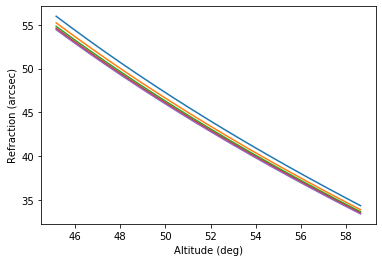

In [139]:
def img_scl_change(wavelength=np.array([400, 500, 600, 700, 800]),\
                   input_times=np.array([1]), latitude=20.71, longitude=-156.25,\
                   altitude=3055., air_temp=20., air_pressure=100000., humidity=75., co2_conc=380., verbose=0):
    #print(input_times)
    num_waves = wavelength.size
    refraction_atm = atmospheric_refraction(wavelength, input_times, latitude, longitude, altitude,\
                                            air_temp, air_pressure, humidity, co2_conc, verbose)
    
    #setting default time to now in Julian dates
    if np.alltrue(input_times == np.array([1])):
        input_times = Time(np.array([datetime.utcnow()]), scale='utc')
        input_times.format = 'jd'
    else:
        input_times = Time(input_times, format='jd', scale='utc')    
    
    #get solar elevation
    sunpos = coordinates.get_sun(input_times)
    haleakalā = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)
    frame_obstime = AltAz(obstime=input_times, location=haleakalā)
    sunpos_altaz  = sunpos.transform_to(frame_obstime)
    elevation_sun = sunpos_altaz.alt.deg
    
    image_fov = 60. #in arcseconds
    image_fov_deg = image_fov/3600.
    
    #range of degrees present on selected day:
    if np.amin(elevation_sun) > 5 and np.amax(elevation_sun) < 90:
        alt_range = np.array([np.amin(elevation_sun), np.amax(elevation_sun)])
    else:
        alt_range = np.array([5, 90])
    #there's probably a more elegant/Python-y way of doing that, but whatever
    #number of divisions per degree on interpolated altitude scale
    alt_scale = 60. 
    #number of steps for altitude scale
    alt_stepn = int(round(((alt_range[1]-alt_range[0]))*alt_scale))
    alt_scl_new = np.arange(alt_stepn)/alt_scale + alt_range[0]
    alt_scl_avg = (alt_scl_new[0:-2] + alt_scl_new[1:-1])/2.
    alt_scl_deg = alt_scl_new[1:-1] - alt_scl_new[0:-2]
    
    image_scale_factor = np.ones((elevation_sun.size, num_waves))
    sun_is_up = np.where(elevation_sun >= 1)
    
    for wv in range(num_waves):
        #calculate  atmospheric refraction on a grid evenly spaced in elevation
        y1 = interpolate.splrep(elevation_sun[sun_is_up],\
                                refraction_atm[0]['refraction_mag (arcsec)'][sun_is_up, wv][0], s=0)
        refraction_mag = interpolate.splev(alt_scl_new, y1, der=0)
        #and plot 
        plt.plot(alt_scl_new, refraction_mag)
#        plt.plot(elevation_sun[sun_is_up],refraction_atm[0]['refraction_mag (arcsec)'][sun_is_up, wv][0],'.')
        plt.xlabel("Altitude (deg)")
        plt.ylabel("Refraction (arcsec)")
        #calculate the difference in refraction between adjacent elevation steps
        refraction_diff = np.median(refraction_mag[0:-2]-refraction_mag[1:-1])
        #normalize the refraction differences to the step size of the degree scale
        refraction_diff_perdeg = refraction_diff/alt_scl_deg
        #multiply the refraction difference (per degree) by the size of the field of view
        refraction_diff_fov = refraction_diff_perdeg*image_fov_deg
        image_scale_cor = 1 - refraction_diff_fov/image_fov
        image_scale_cor_time = interpolate.interp1d(alt_scl_avg, image_scale_cor, fill_value = 'extrapolate')
        #plt.plot(elevation_sun, image_scale_cor_time(elevation_sun))
        #plt.ylabel("Image Scale Difference Ratio")
        #plt.xlabel("Altitude (deg)")

img_scl_change(input_times=2459383.3 + np.arange(60)/1440)
#img_scl_change()